***1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_classification

In [2]:
# сгенерируем данные, представляющие собой 1000 объектов с 2 признаками
classification_data, classification_labels = make_classification(n_samples=1000,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=23)

In [3]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [4]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с 1, 3, 10 и 50 деревьями.

In [23]:
n_trees = [1, 3, 10, 50]
forests = {}
for i in range(len(n_trees)):
    forests[f"forest_{i + 1}"] = random_forest(train_data, train_labels, n_trees[i])

In [24]:
# Получим ответы для обучающей и тестовой выборки
train_answers, test_answers = {}, {}
for forest_name, forest in forests.items():
    train_answers[forest_name] = tree_vote(forest, train_data)
    test_answers[forest_name] = tree_vote(forest, test_data)

In [25]:
# Точность на обучающей выборке
train_accuracy = {}
for forest_name, answers in train_answers.items():
    train_accuracy[forest_name] = accuracy_metric(train_labels, answers)
n = 0
for v in train_accuracy.values():
    print(f'Точность случайного леса из {n_trees[n]} деревьев на обучающей выборке: {v:.3f}')
    n += 1

# Точность на тестовой выборке
test_accuracy = {}
for forest_name, answers in test_answers.items():
    test_accuracy[forest_name] = accuracy_metric(test_labels, answers)
n = 0
for v in test_accuracy.values():
    print(f'Точность случайного леса из {n_trees[n]} деревьев на тестовой выборке: {v:.3f}')
    n += 1

Точность случайного леса из 1 деревьев на обучающей выборке: 96.571
Точность случайного леса из 3 деревьев на обучающей выборке: 98.143
Точность случайного леса из 10 деревьев на обучающей выборке: 99.571
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 1 деревьев на тестовой выборке: 85.667
Точность случайного леса из 3 деревьев на тестовой выборке: 89.333
Точность случайного леса из 10 деревьев на тестовой выборке: 88.000
Точность случайного леса из 50 деревьев на тестовой выборке: 90.333


In [36]:
# Визуализируем дерево на графике

from matplotlib.colors import ListedColormap

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, forest, train_labels, test_labels, train_accuracy, test_accuracy):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<ipython-input-36-dbab57c1ffac>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-36-dbab57c1ffac>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


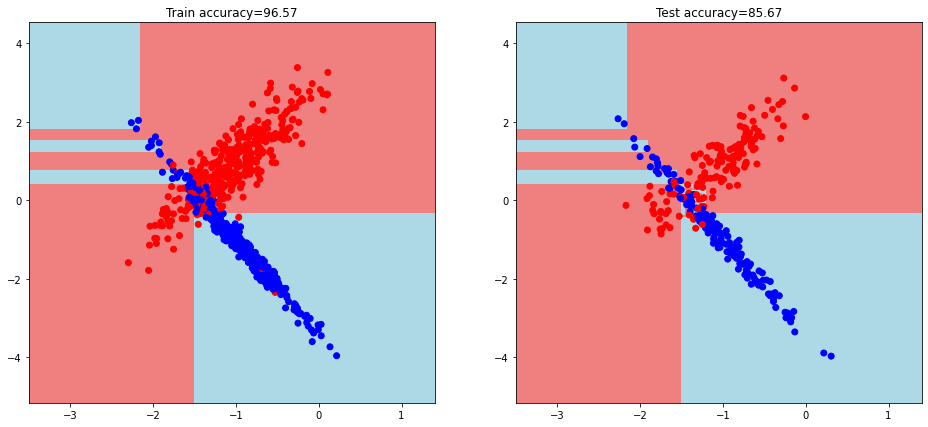

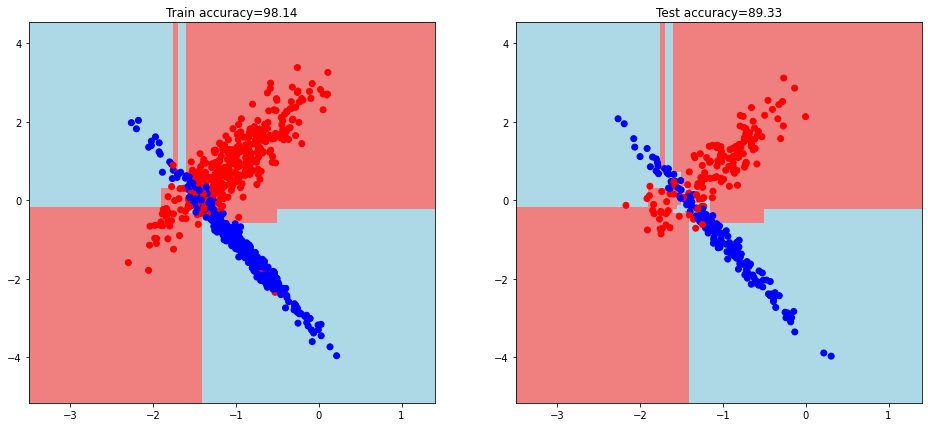

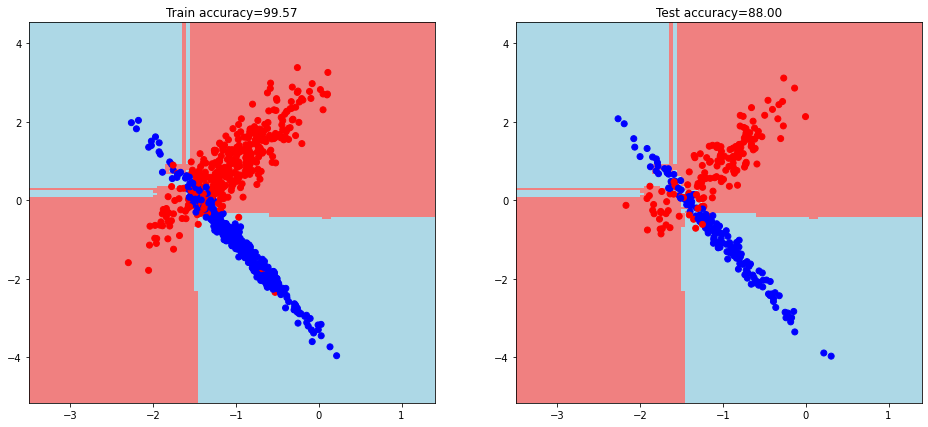

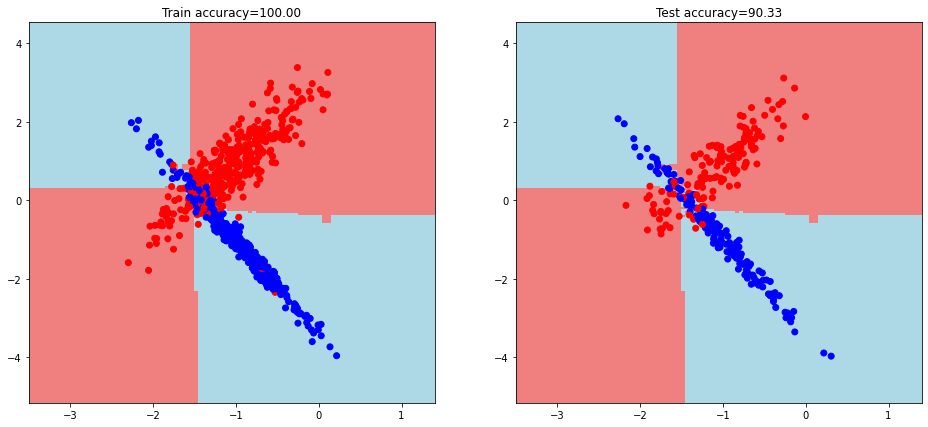

In [37]:
for i in range(1, len(n_trees) + 1):
    visualize(train_data, test_data, forests[f"forest_{i}"],  train_labels, test_labels, train_accuracy[f"forest_{i}"], test_accuracy[f"forest_{i}"])

***2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.***

С увеличением количества деревьев в случайном лесу сложность гиперплоскости не увеличивается (как будто даже снижается), модель обучается лучше, но не переобучается. При небольшом количестве деревьев модель обучается недостаточно хорошо.

***3.* Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.***

In [45]:
# Изменим функцию get_bootstrap - теперь она возращает bootstrap и индексы данных, не вошедших в bootstrap (residual)
np.random.seed(42)

def get_bootstrap_and_residual(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    residual = [] # сюда функция помещает остаточные индексы
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        residual_index = [i for i in range(n_samples) if i not in sample_index] # для каждого дерева находим residual
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        residual.append(residual_index) # добавляем список residual для дерева в общий список
        bootstrap.append((b_data, b_labels))
        
    return bootstrap, residual

In [46]:
# немного меняем функцию random_forest - возвращает forest и residual

def random_forest_2(data, labels, n_trees):
    forest = []
    bootstrap, residual = get_bootstrap_and_residual(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, residual

In [57]:
# предсказание для объектов, на которых дерево не обучается
# функция возвращает предсказания в виде списка, содержащего предсказание для каждого объекта или None, если не было деревьев, которые не обучались на нем

def tree_vote_residual(forest, data, residual):
    
    prediction_list = [[] for _ in range(len(data))] # сюда будем добавлять индексы деревьев, не обучавшихся на объекте
    for i in range(len(residual)):
        for el in residual[i]:
            prediction_list[el].append(i)


    # добавим предсказания в список и помещаем в общий список
    predictions_first_step = [[] for _ in range(len(data))]
    for i in range(len(prediction_list)):
        if len(prediction_list[i]) != 0:
            for tree in prediction_list[i]:
                predictions_first_step[i].append(classify_object(data[i], forest[tree]))


    # выберем в качестве итогового предсказания для каждого объекта то, за которое проголосовало большинство деревьев
    predictions = []
    for i in range(len(predictions_first_step)):
        if len(predictions_first_step[i]) != 0:
            predictions.append(max(set(predictions_first_step[i]), key=predictions_first_step[i].count))
        else:
            predictions.append(None)
        
    return predictions

Теперь построим случайный лес с 50 деревьями.

In [49]:
n_trees = 50
my_forest, residual = random_forest_2(classification_data, classification_labels, n_trees)

In [50]:
# Получим ответы для всей выборки 
answers = tree_vote(my_forest, classification_data)

In [58]:
# И получим предсказания для объектов, не участвовавших в обучении деревьев
oob_answers = tree_vote_residual(my_forest, classification_data, residual)

In [60]:
# Точность на всей выборке
train_accuracy = accuracy_metric(classification_labels, oob_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 92.000


In [65]:
# Поменяем немного accuracy_metric

def accuracy_metric_2(actual, predicted):
    correct = 0
    n_none = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
        elif actual[i] != predicted[i] and predicted[i] == None:
            n += 1
    return correct / float(len(actual) - n_none) * 100.0


In [66]:
# Точность на тестовой выборке

oob = accuracy_metric_2(classification_labels, oob_answers)
print(f'OOB случайного леса из {n_trees} деревьев: {oob:.3f}')

OOB случайного леса из 50 деревьев: 92.000
